In [1]:
import csv 
import numpy as np
import pandas as pd
import sys
import platform
system = platform.system()
if system =='Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system =='Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
path2curve = 'Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv'
curve = OCVcurve(path2curve)

### Import the test file

In [253]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Luigi/'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/Luigi/'
    
log_file = analog.pathfromQGC(folder,index=89)

#log_file = analog.pathfromgazebo('2019-10-29','09_24_54',firmware='yuneec')

print(log_file)
info = analog.logextract(log_file,['battery_status','vehicle_local_position'])
print(info.keys())
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
covx = info['covx']
time = info['time_bs']
voltage = info['battery_voltage']/4
x = info['x']
y = info['y']
z = info['z']
L = info['kalman_gain']
inno = info['innovation']
iR1 = info['iR1']
time_vlp = info['time_vlp']

/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/Luigi//log_89_2019-10-29-19-10-58.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining', 'covx', 'kalman_gain', 'innovation', 'iR1'])


# Kalman filter analysis

## Vehicle position

<IPython.core.display.Javascript object>


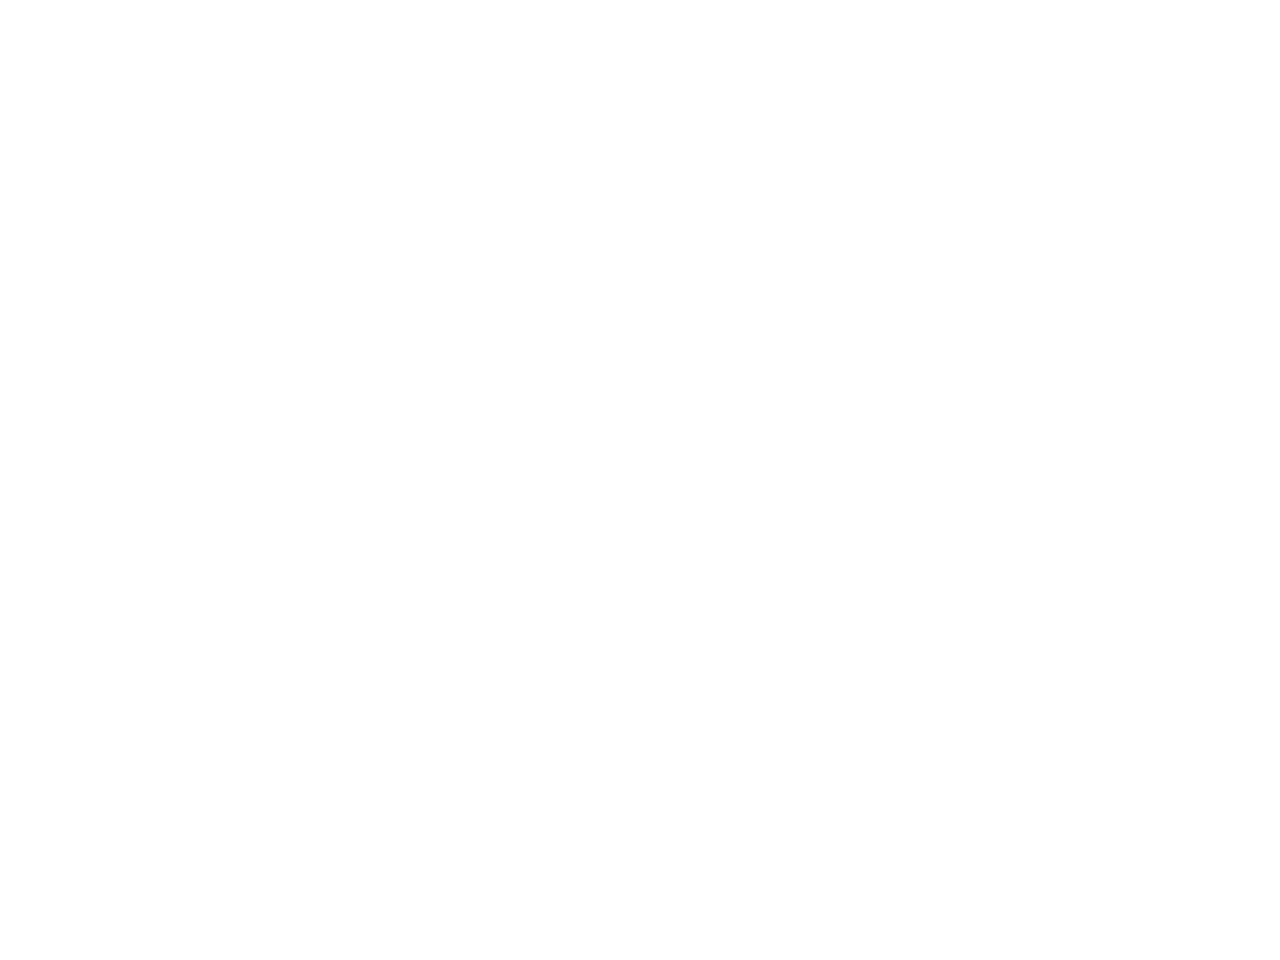

In [254]:
plt.figure()
plt.plot(time_vlp,x,label='x')
plt.plot(time_vlp,y,label='y')
plt.plot(time_vlp,z,label='z')
plt.xlabel('time (s)')
plt.legend()
plt.grid()

## Battery in & out

In [255]:
current_filtered_new = []
current_filtered_new = np.array(current[0:2])

for k in range(2,len(current)):
    current_filtered_new = np.append(current_filtered_new,0.02*current[k]+0.98*current_filtered_new[k-1]+0.00*current_filtered_new[k-2])

<IPython.core.display.Javascript object>


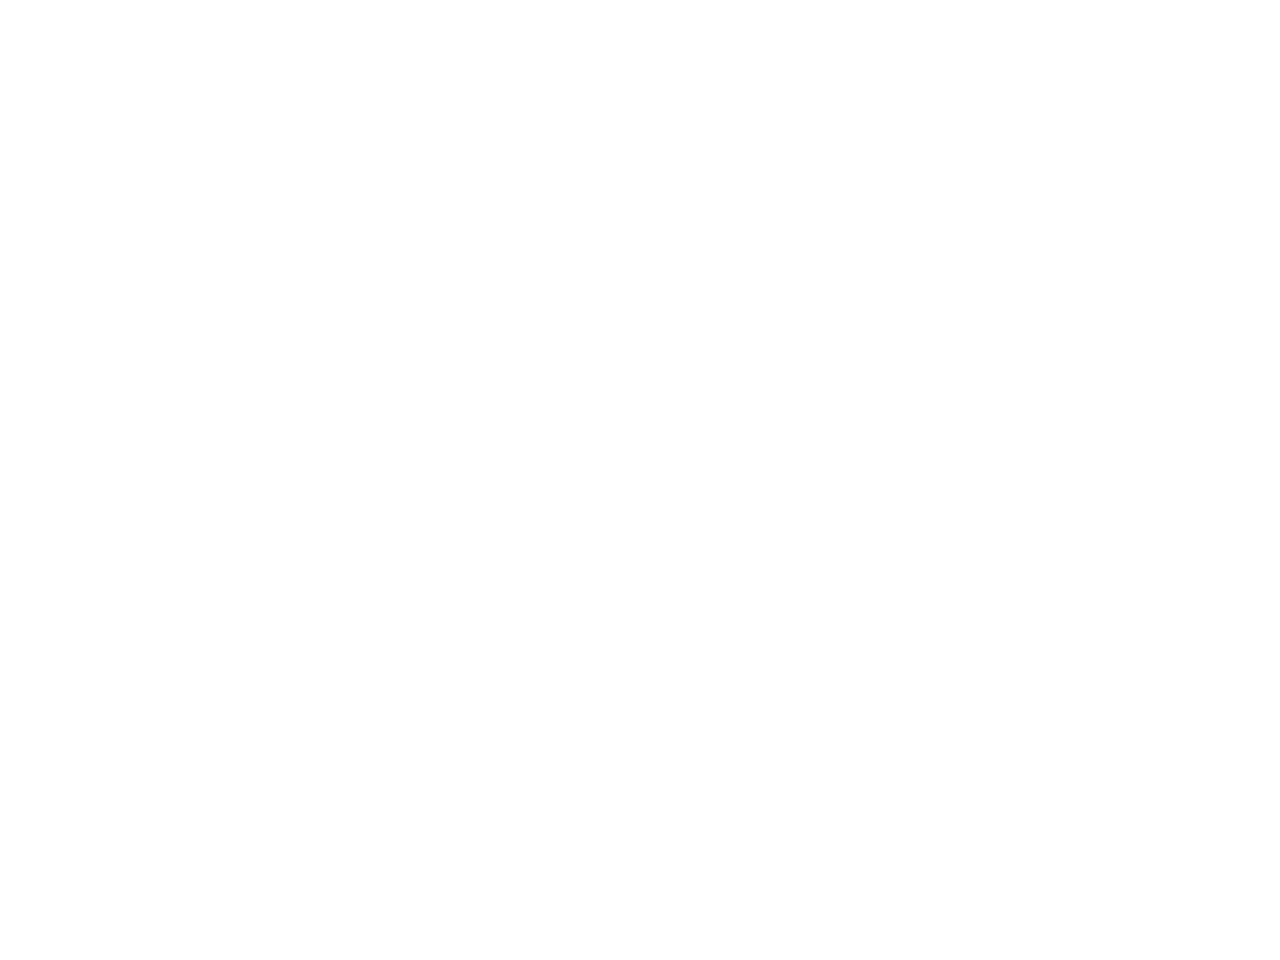

3.9372802


In [256]:
%matplotlib notebook
plt.subplot(121)
plt.plot(time,voltage)
plt.grid()
plt.ylabel('Cell terminal voltage (V)')
plt.subplot(122)
plt.plot(time,current,label='unfiltered')
plt.plot(time,current_filtered,label='filtered')
#plt.plot(time,current_filtered_new,label='filtered new')
plt.legend()
plt.grid()
plt.ylabel('Current (A)')
plt.show()
print(voltage[0])

In [257]:
current[time>100][0]
print((4.16-4.08)/5.35)

0.014953271028037398


## State estimation

<IPython.core.display.Javascript object>


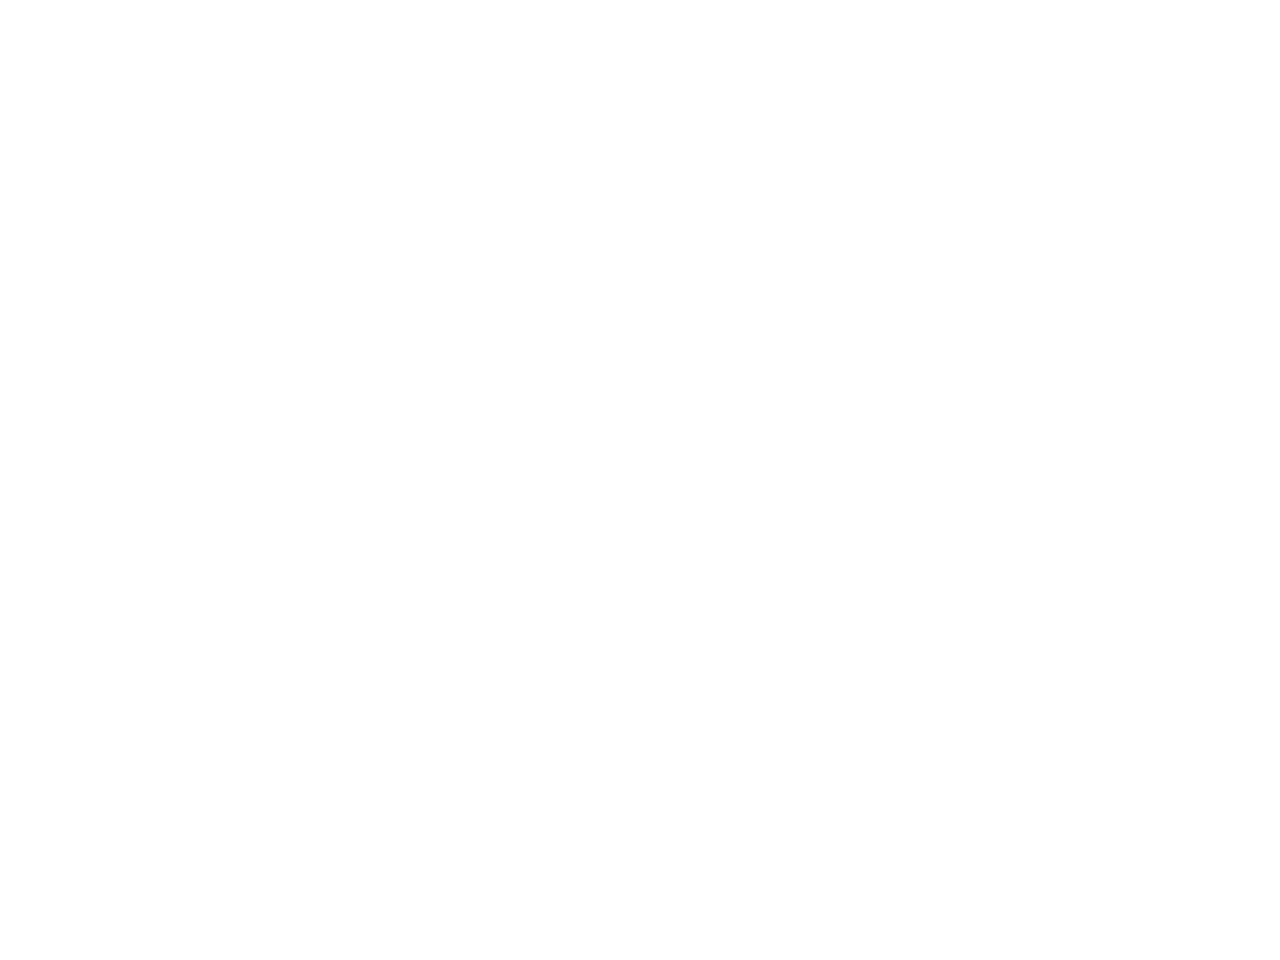

In [258]:
plt.figure()
plt.plot(time,SOC)
plt.axhline(0,color='r')
plt.axhline(1,color='r')
plt.grid()
plt.show()

In [259]:
SOC[time>110][0]-SOC[time>80][0] # about 4% increase due to current

0.043971002

# Covariance of states

<IPython.core.display.Javascript object>


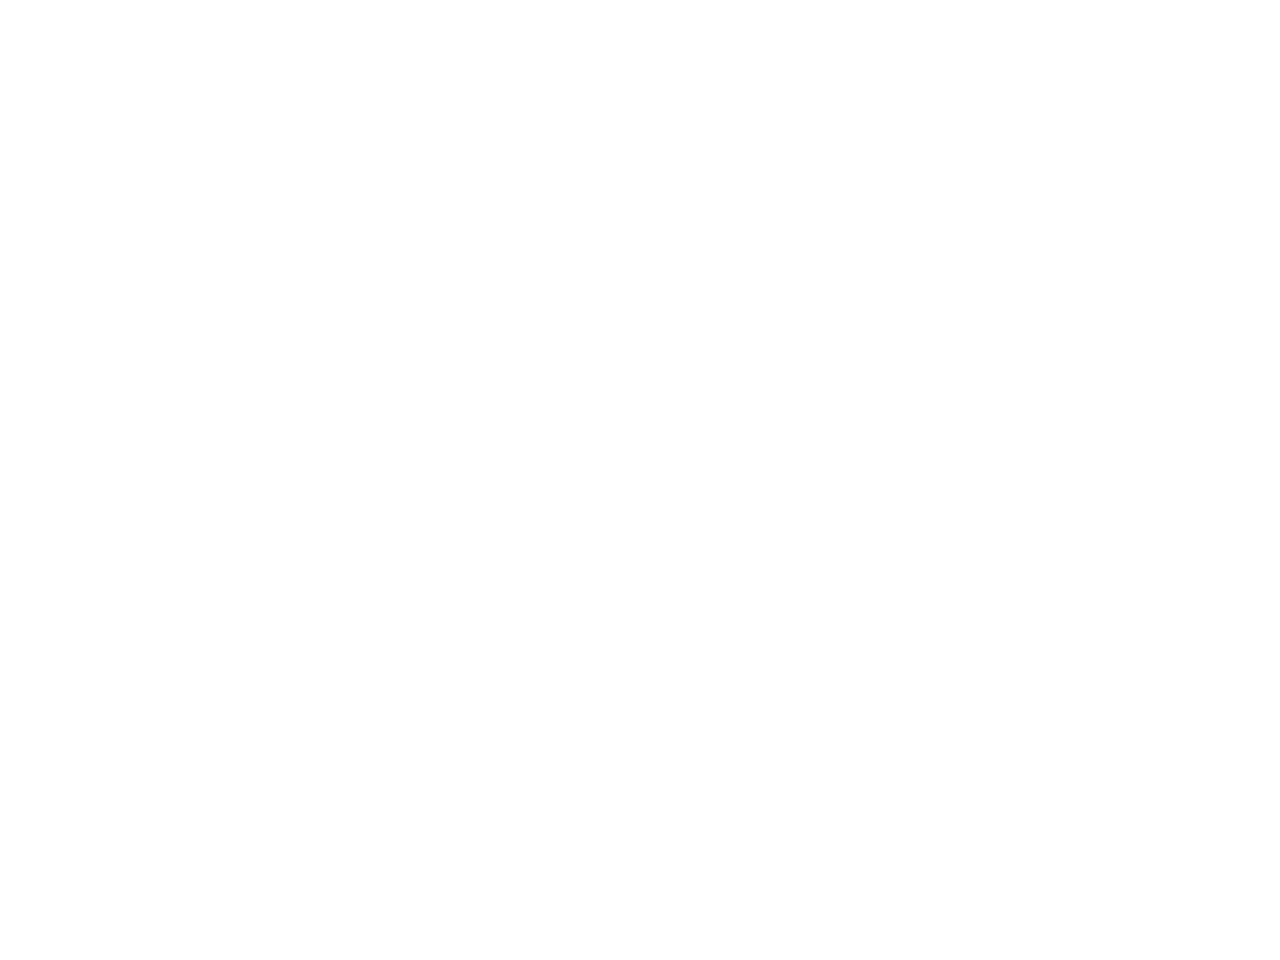

[[1.4014038e-01 2.7348459e-08]
 [2.7348459e-08 9.9999997e-06]]
[[2.4306101e-01 2.8871204e-08]
 [2.8871204e-08 9.9999997e-06]]


In [260]:
# initialization is done at (0.3,0);(0,0.1)

plt.figure()
plt.suptitle('covx')

plt.subplot(221)
plt.plot(time,covx[0,0])
plt.grid()

plt.subplot(222)
plt.plot(time,covx[0,1])
plt.grid()

plt.subplot(223)
plt.plot(time,covx[1,0])
plt.xlabel('time (s)')
plt.grid()

plt.subplot(224)
plt.plot(time,covx[1,1])
plt.xlabel('time (s)')
plt.grid()

# must be symetric and positive-definite at all times 

print(covx[:,:,0])
print(covx[:,:,-1])

## Kalman gain & innovation

In [261]:
measurement_update0 = []
measurement_update1 = []

for k in range(len(inno)):
    measurement_update0 = np.append(measurement_update0,L[0,0,k]*inno[k])
    measurement_update1 = np.append(measurement_update1,L[1,0,k]*inno[k])

<IPython.core.display.Javascript object>


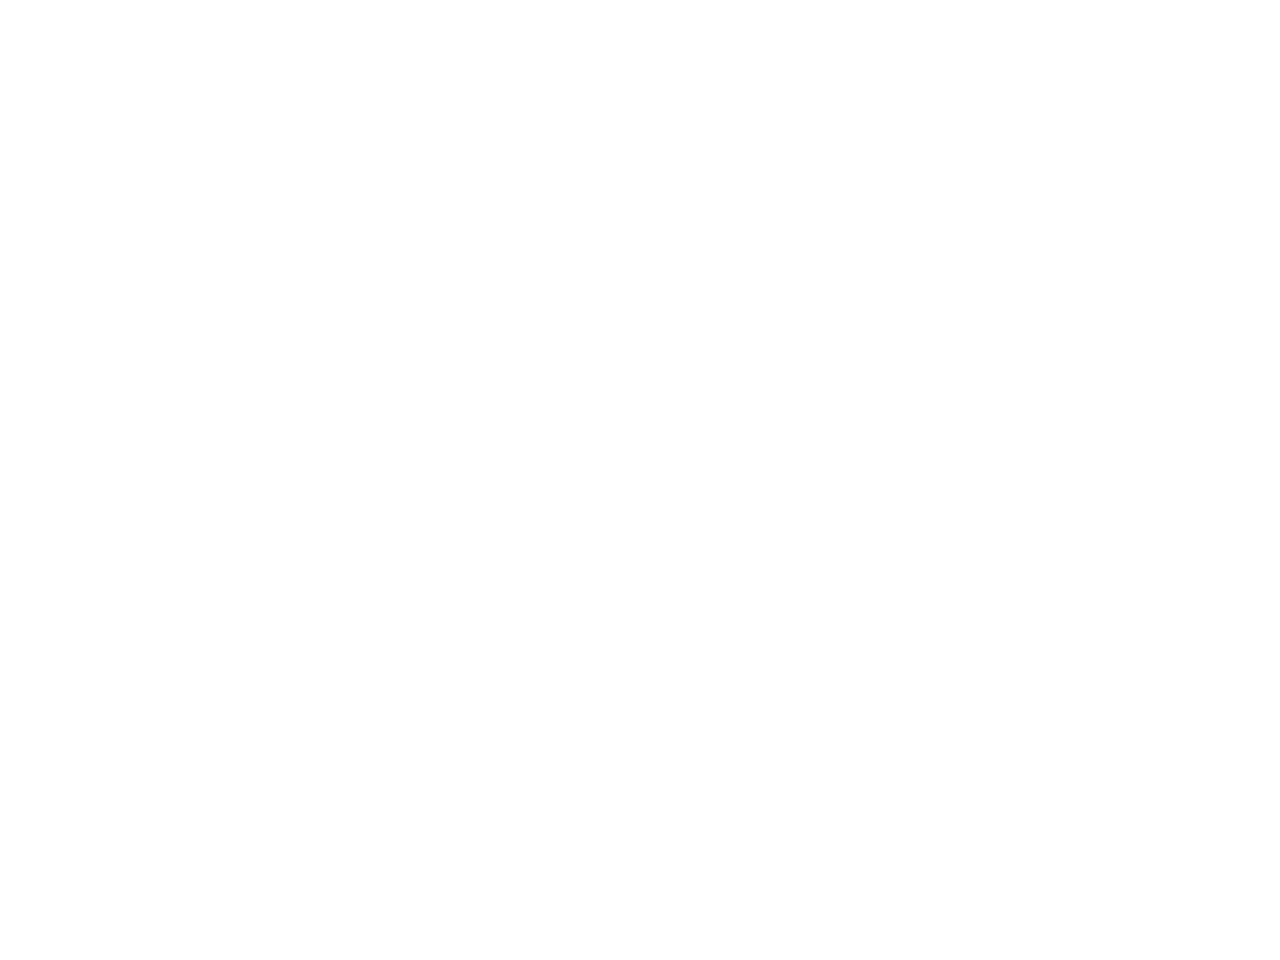

In [262]:
plt.figure()
plt.subplot(221)
plt.title('Kalman gain (0=discard measurement)')
plt.plot(time,L[0].transpose(),label='L(0)')
plt.plot(time,L[1].transpose(),label='L(1)')
plt.grid()
plt.legend()

plt.subplot(222)
plt.title('Innovation')
plt.plot(time,inno) # inno = y - yhat
plt.grid()

plt.subplot(223)
plt.title('Measurement correction xhat(0)')
plt.plot(time,measurement_update0)
plt.grid()

plt.subplot(224)
plt.title('Measurement correction xhat(1)')
plt.plot(time,measurement_update1)
plt.grid()

In [263]:
L[1] # = covx(1,1)*C(1) = 1e-5*-R1 = -1e-5*1e-2 = 1e-7

array([[-1.4595182e-07, -1.4362682e-07, -1.4592547e-07, ...,
        -1.6556871e-07, -1.6382791e-07, -1.6502858e-07]], dtype=float32)

In [264]:
L[0,0,time>98][0]*inno[time>98][0:12]
# this is negative, so the measurement state update tends to decrease the SOC (not the origin of the problem -> B(0) must be wrong)

array([0.00090922, 0.00121294, 0.00152764, 0.00171706, 0.00200259,
       0.0021043 , 0.00182052, 0.00157641, 0.00138702, 0.00130287,
       0.001157  , 0.00107141], dtype=float32)

In [265]:
L[0,0,91]*inno[91] # direct impact on SOC ! +16% -> corresponds more or less to the error in SOC 

0.0006413153

<IPython.core.display.Javascript object>


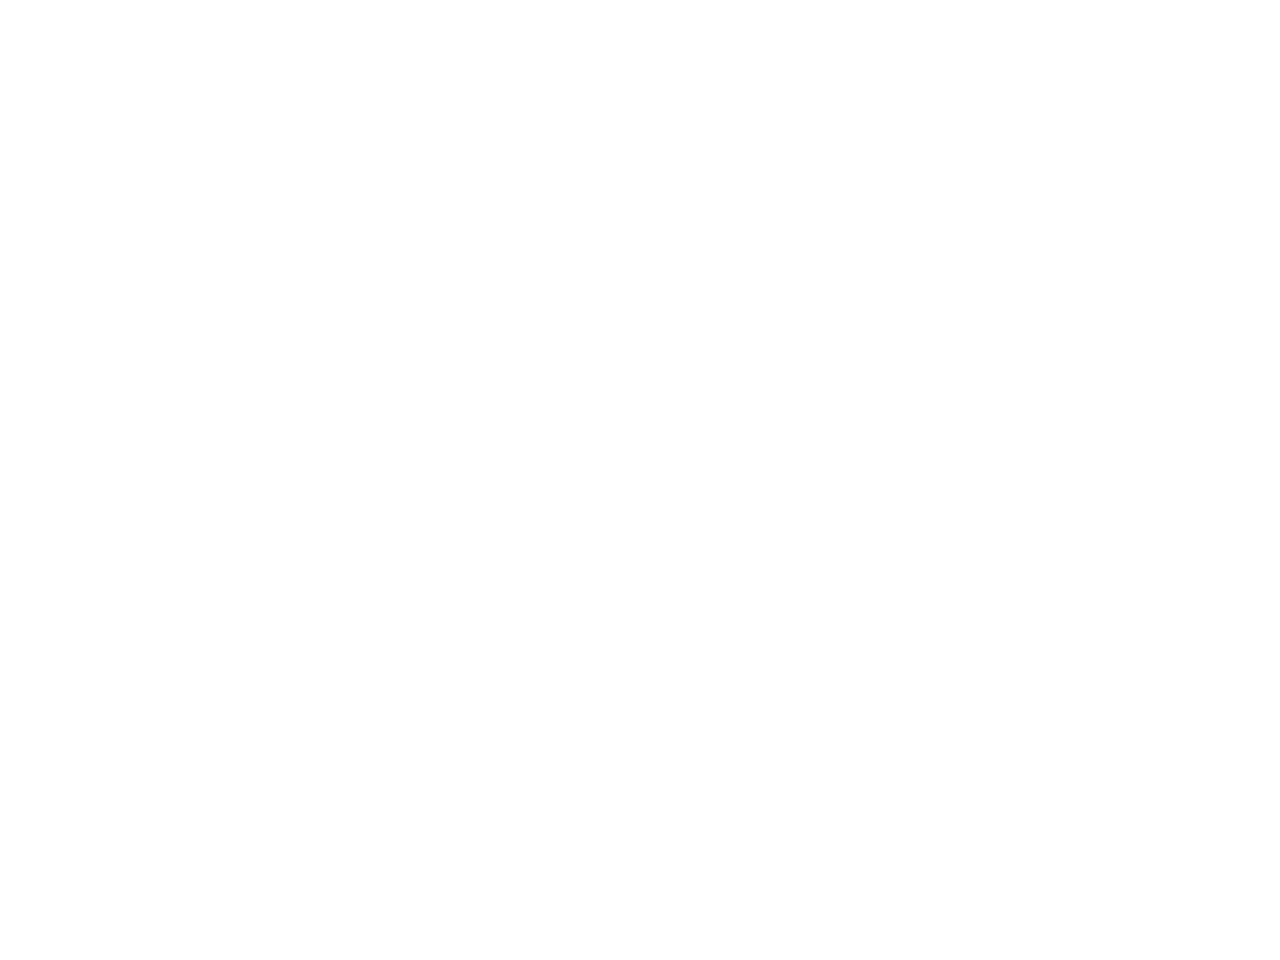

In [266]:
y = voltage
yhat = y - inno

plt.figure()
plt.plot(time,y,label='output')
plt.plot(time,yhat,label='estimate')
plt.grid()
plt.legend()
plt.show()

In [267]:
yhat[91] # exactly the problematic value !

3.9366927

<IPython.core.display.Javascript object>


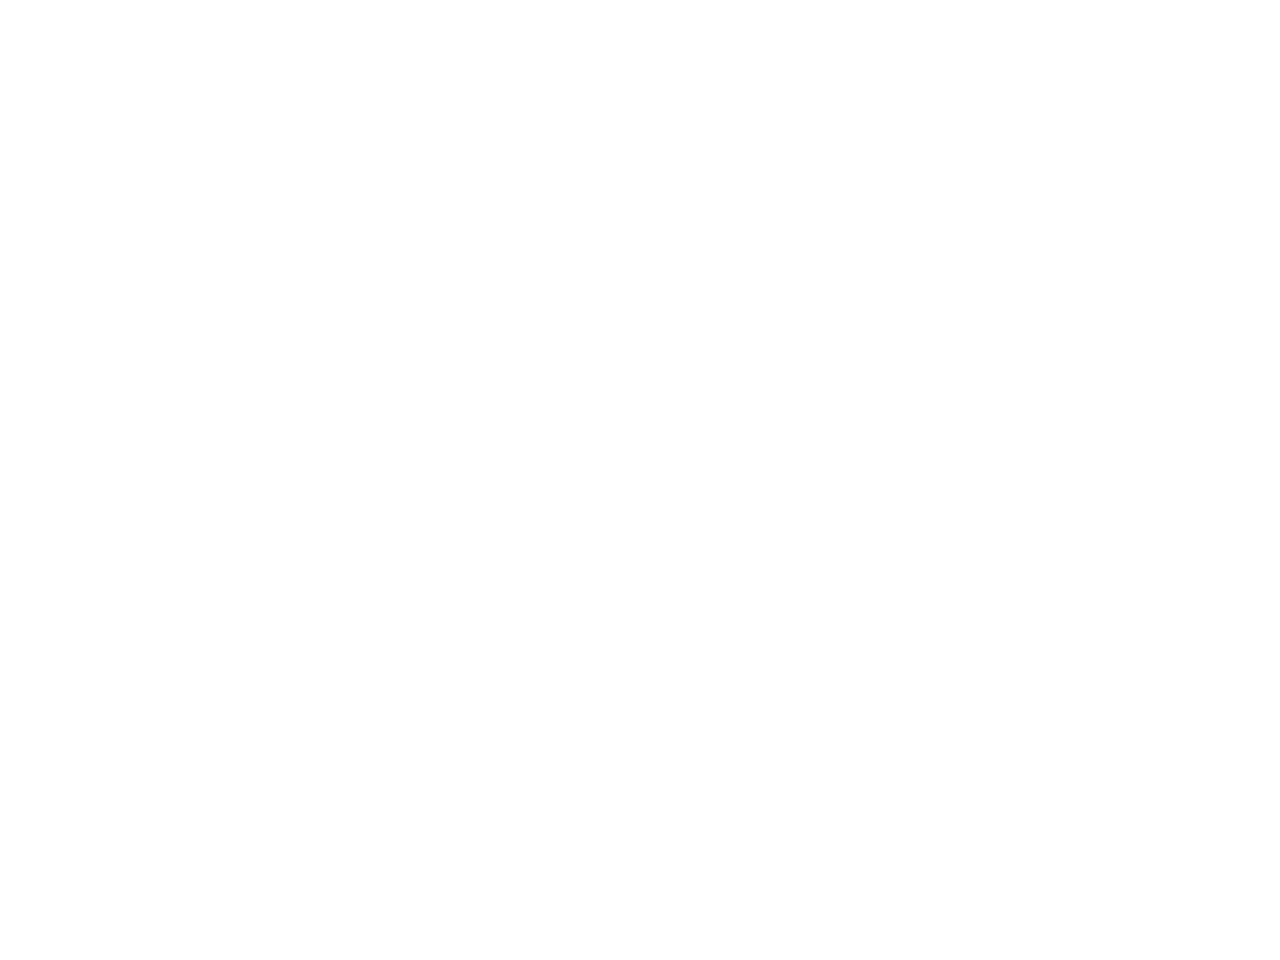

In [268]:
plt.figure()
plt.plot(time,iR1)
plt.grid()

In [269]:
# Critial timestep k=104
print(L[1,0,104]*inno[104])
print(iR1[104])
print(current[104:110])

-6.991687e-10
-6.991684e-10
[0. 0. 0. 0. 0. 0.]


# Simulation


In [270]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.002
R1 = float(ECparams['R1'])
R1 = 0.02
C1 = float(ECparams['C1'])
C1 = 300
print([R0,R1,C1])

[0.002, 0.02, 300]


### Tune some more simulation parameters

In [271]:
Q = 6230*3.6 # has to be in Coulombs
eta = 1
z0 = curve.SOCfromOCV(np.mean(voltage[0])+R0*current[0]) # taken from log to be tested
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.6295909610367834


In [272]:
print(f'True measured initital voltage is {voltage[0]:.2f} V')
print(f'True initial OCV would then be {voltage[0]+R0*current[0]:.2f} V, because initial current is {current[0]:.2f} A')

True measured initital voltage is 3.94 V
True initial OCV would then be 3.94 V, because initial current is 0.00 A


### Run the simulation using the state-space model

<IPython.core.display.Javascript object>


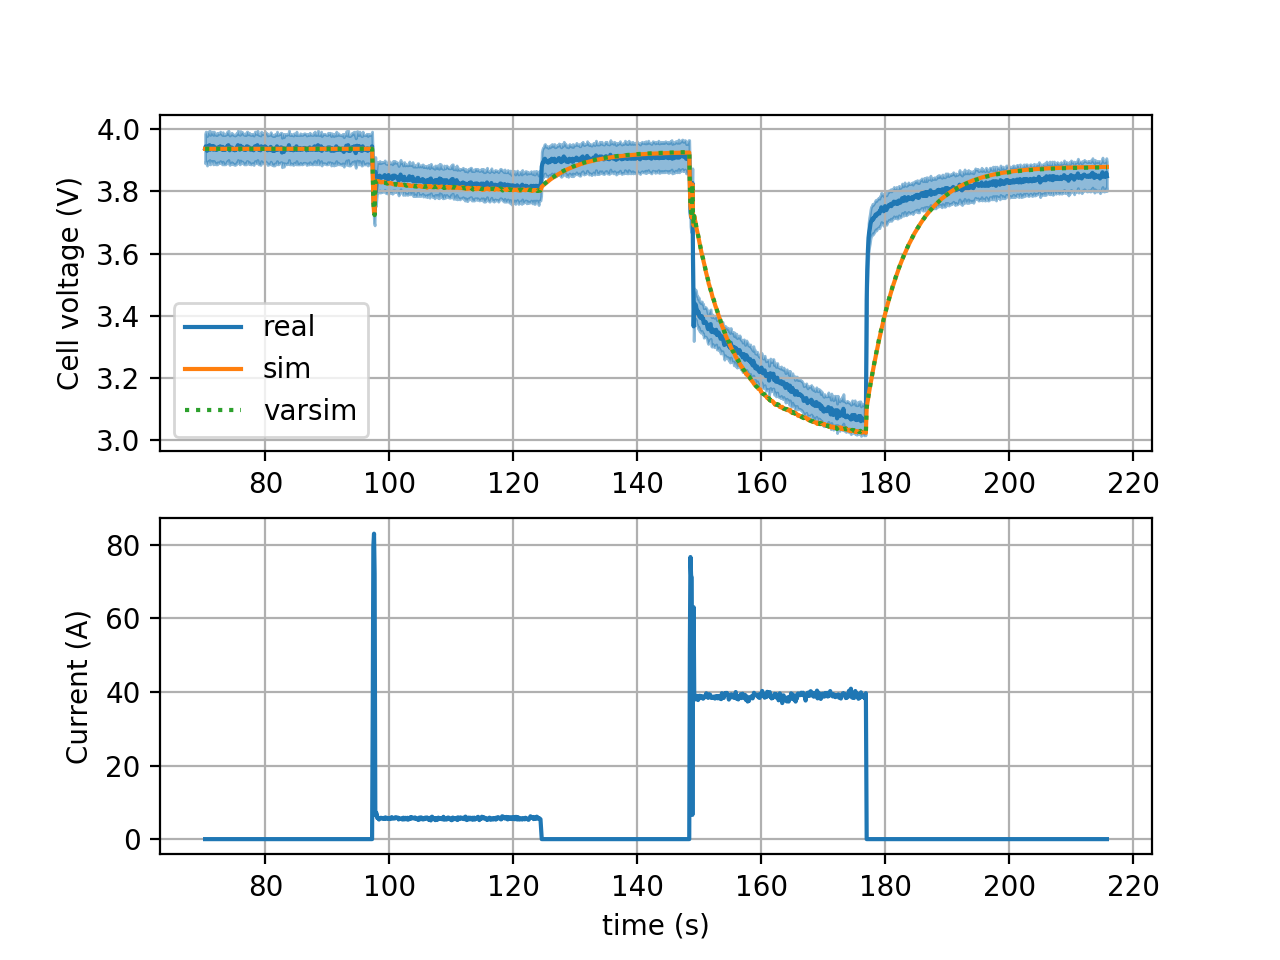

In [273]:
%matplotlib notebook
vsim = battery.simulate(time,current,plot=False)
battery.statespace(np.mean(np.diff(time)))
vlsim = battery.lsim(time,current,curve)
varsimv = battery.varsim(time,current,curve)
std = 0.023633527

plt.figure()
plt.subplot(211)
plt.fill_between(time,voltage + 2*std, voltage - 2*std,color='C0', alpha=.5)
plt.plot(time,voltage,color='C0',label='real')

plt.plot(time,vsim,color='C1',label='sim',alpha=1)
#plt.plot(time,vlsim+3.6,label='linsim')
plt.plot(time,varsimv,color='C2',label='varsim',linestyle=':')
plt.legend()
plt.grid()
plt.ylabel('Cell voltage (V)')
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('Current (A)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


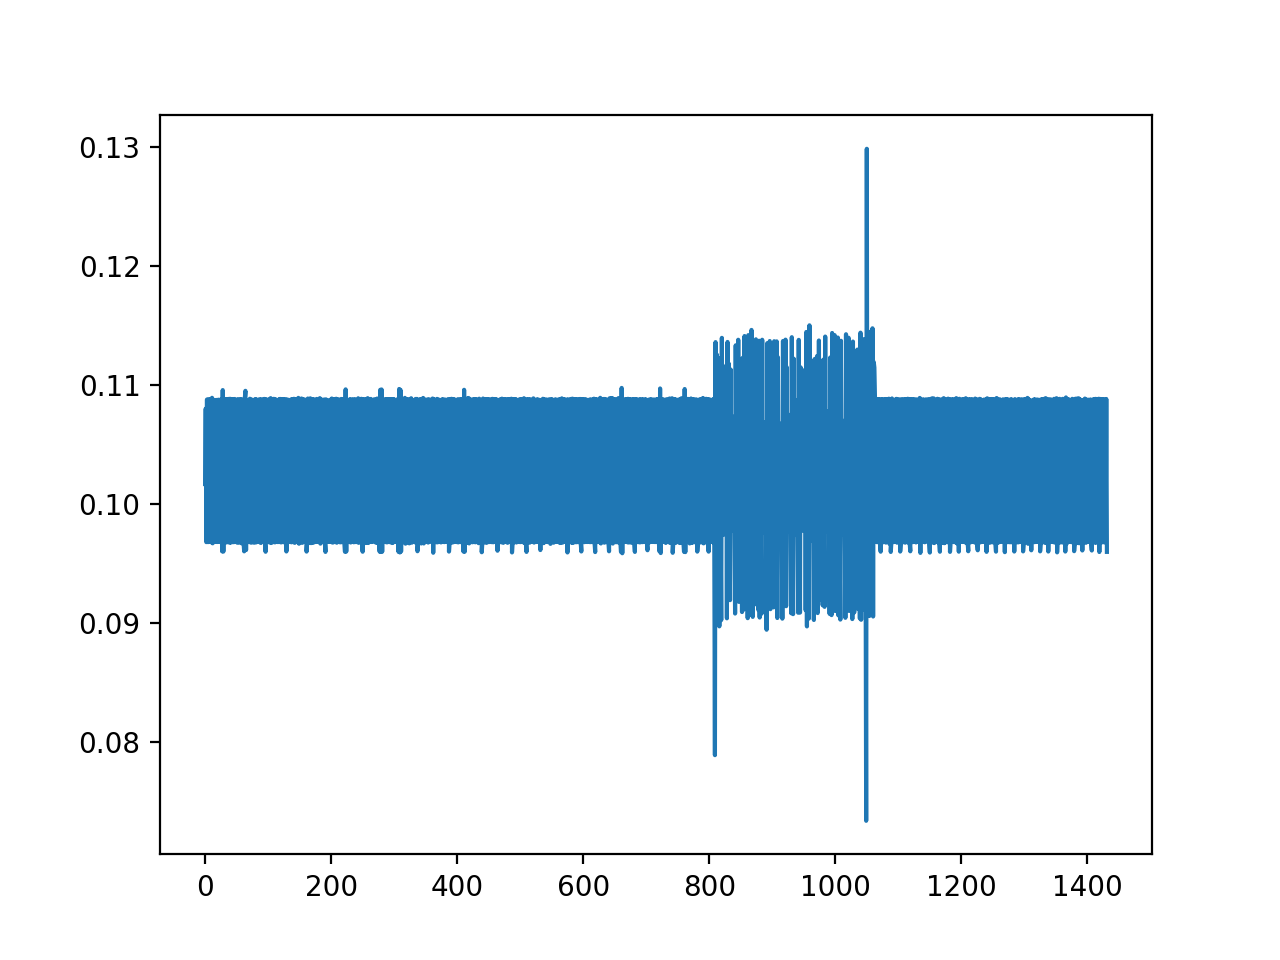

In [274]:
plt.figure()
plt.plot(battery.varsimdt)
plt.show()

In [275]:
xplus0 = np.array([[z0],[0.]]) # is a stack of 2x1 arrays = a 2xk array
covxplus0 = np.array([[0.1,0.],[0., .1]]) # is a stack of 2x2 arrays

covw = np.array([[0.1, 0.],[0., 0.1]]) # is a constant 2x2 array
covv = 0.5017+0.5 # is a constant 1x1 array

xminus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covmxminus = np.array([]) # is a stack of 2x2 arrays
yhat = np.array([]) # is a stack of 1x1 arrays = a 1-D array
xplus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covxplus = np.array([]) # is a stack of 2x2 arrays
covxy = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covy = np.array([]) # is a stack of 1x1 arrays = a 1-D array
L = np.array([]) # is a stack of stack of 2x1 arrays = a 1-D array

u = current # is a stack of 1x1 arrays = a 1-D array
y = voltage # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

In [283]:
n = len(time)-1
for k in range(len(y[:n+1])):
    #print(f'\n New iteration k={k}')
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus[1,-1]}')
    
    if k == 0: 
        kfbat.reset(R0,R1,C1,xplus0[0])
    else: 
        kfbat.reset(R0,R1,C1,xplus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    #print(f'Matrix C is {kfbat.C}')
    
    
    # 1 : Prediction update
    
    # 1a State prediction
    
    if k==0: 
        alpha = np.reshape(kfbat.A@xplus0,(2,1))
        xminus = alpha
    
    else : 
        alpha = np.reshape(kfbat.A@xplus[:,k-1],(2,1))
        beta = kfbat.B*u[k-1]
        xminus = np.concatenate([xminus, alpha + beta],axis=1)
    
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus[1,-1]}')
    
    
    #print(f'xminus is {np.shape(xminus)}, should be 2x{k+1}')
    
    kfbat.reset(R0,R1,C1,xminus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    # 1b State covariance a priori
    
    if k==0 :
        covxminus = kfbat.A@covxplus0@kfbat.A.T + covw
    elif k==1: 
        covxminus = np.dstack([covxminus,kfbat.A@covxplus@kfbat.A.T + covw])
    else :
        covxminus = np.dstack([covxminus,kfbat.A@covxplus[:,:,-1]@kfbat.A.T + covw])
    #print(f'covxminus = {covxminus}')    
    #print(f'covxminus is {np.shape(covxminus)}, should be 2x2x{k+1}')
    
    # 1c : Output predicition
    
    if k==0: 
        yhat = kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]
    else : 
        yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]]) 
    #print(f'y : {y[k]}')  
    #print(f'yhat : {yhat[k]}')
    #print(f'yhat is {np.shape(yhat)}, should be {k+1}')
    
    # 2 : Measurement update
    
    # 2a Kalman gain computation
    
    if k==0:
        covxy = np.reshape(covxminus@kfbat.C.T,(2,1))
        covy = np.reshape(kfbat.C@covxminus@kfbat.C.T + covv,1)
        L = covxy/covy
    else : 
        covxy = np.concatenate([covxy,np.reshape(covxminus[:,:,k]@kfbat.C.T,(2,1))],axis=1)
        #print(f'covxy is {np.shape(covxy)}, should be {2,k+1}')
        #print(np.shape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv))
        covy = np.concatenate([covy,np.reshape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv,1)])
        L = np.concatenate([L,covxy/covy],axis=1)
    #print(f'covy is {np.shape(covy)}, should be {k+1}')
    
    #print(f'covxy = {covxy[:,k]}')      
    #print(f'Lk={np.reshape(L[:,-1],(2,1))}')
    
    #print(f'L is {np.shape(L)}, should be 2x{k+1}')
          
    # 2b State estimate correction
          
    inno = y[k] - yhat[k]
    #print(f'Innovation : {inno}')
    
    if k==0:
        xplus = xplus0  
    else : 
        xplus = np.concatenate([xplus,np.reshape(xminus[:,k],(2,1)) + np.reshape(L[:,k]*inno,(2,1))],axis=1) 
    #print(f'xplus is {np.shape(xplus)}, should be 2x{k+1}')
        if xplus[0,k] > 1.0:
            xplus[0,k] = 1.0
        elif xplus[0,k] < 0.0:
            xplus[0,k] = 0.0
    
    # 2c State covariance a posteriori 
    if k==0: 
          covxplus = covxminus - L*kfbat.C@covxminus
    else :
        covxplus = np.dstack([covxplus,covxminus[:,:,k] - L[:,k]*kfbat.C@covxminus[:,:,-1]])
        #print(covxplus[:,:,k])
    #print(f'covxplus is {np.shape(covxplus)}, should be 2x2x{k+1}')    
    

<IPython.core.display.Javascript object>


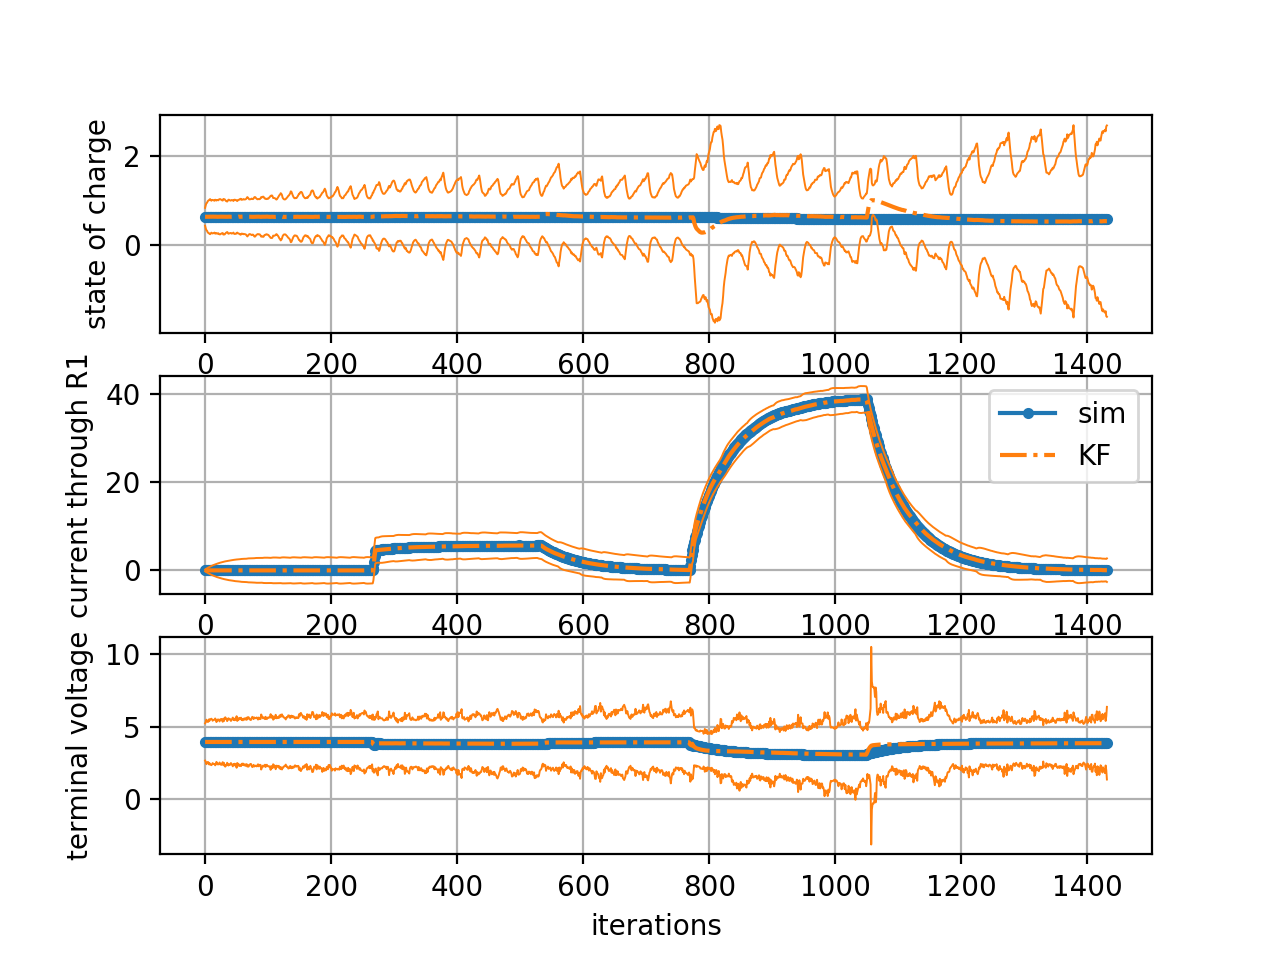

In [284]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure()
plt.subplot(311)
plt.plot(battery.simz[:n+1],'.-')
plt.plot(xminus[0,:],linestyle='-.')
plt.plot(xminus[0,:]+covxminus[0,0,:],color=colors[1],linewidth=0.7)
plt.plot(xminus[0,:]-covxminus[0,0,:],color=colors[1],linewidth=0.7)
#plt.plot(xplus[0,:],'.-')
plt.ylabel('state of charge')
plt.grid()
plt.subplot(312)
plt.plot(battery.simi1[:n+1],'.-',label='sim')
plt.plot(xplus[1,:],'-.',color = colors[1],label='KF')
plt.plot(xplus[1,:]+covxplus[1,1,:],color=colors[1],linewidth=0.7)
plt.plot(xplus[1,:]-covxplus[1,1,:],color=colors[1],linewidth=0.7)
plt.legend()
plt.ylabel('current through R1')
plt.grid()
plt.subplot(313)
plt.plot(battery.simv[:n+1],'.-',label='sim')
plt.plot(yhat,'-.')
plt.plot(yhat+covy,color=colors[1],linewidth=0.7)
plt.plot(yhat-covy,color=colors[1],linewidth=0.7)
plt.xlabel('iterations')
plt.ylabel('terminal voltage')
plt.grid()

# Output comparison

<IPython.core.display.Javascript object>


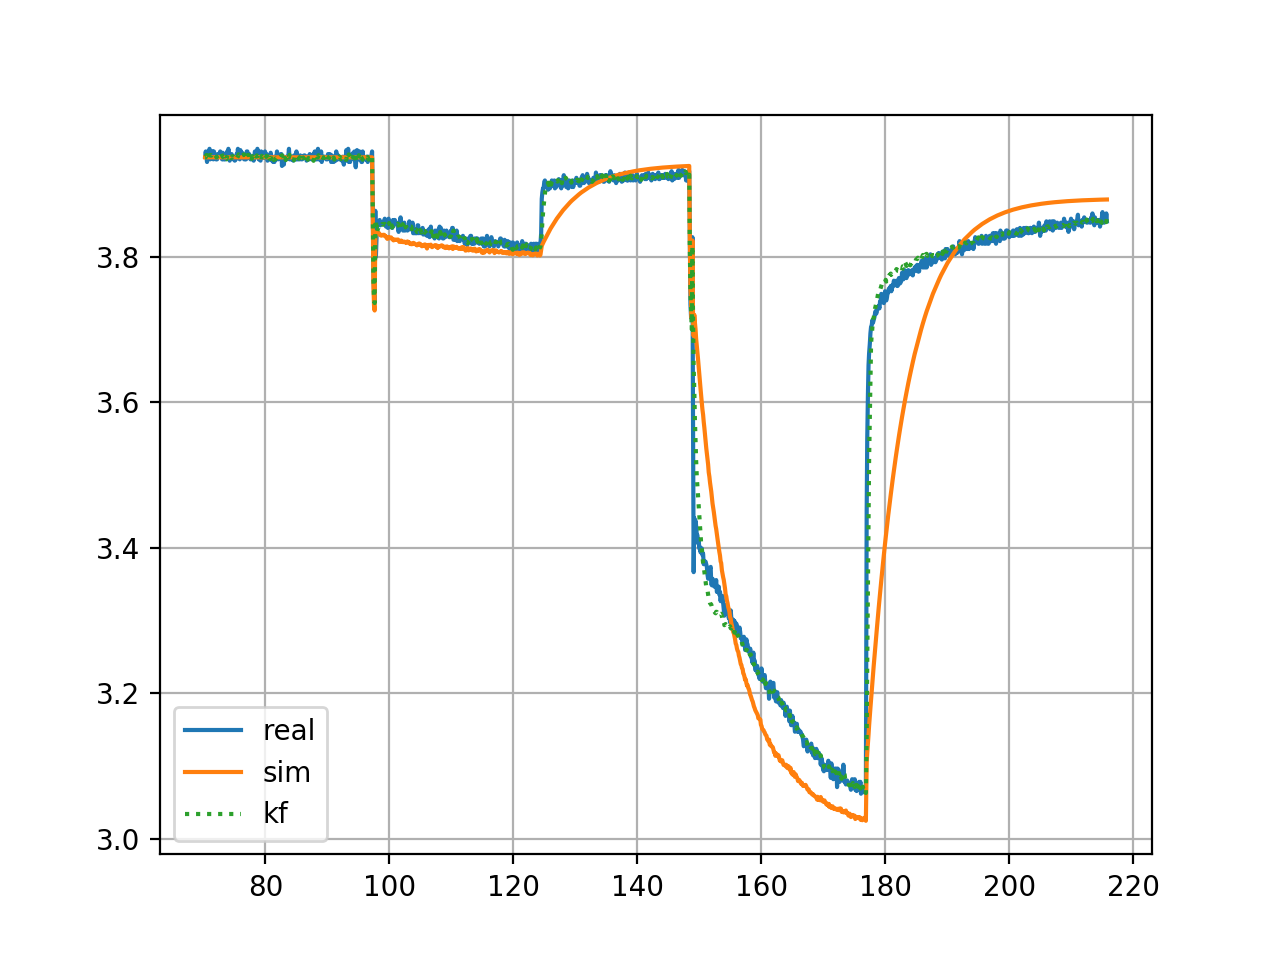

In [285]:
plt.figure()
plt.plot(battery.simt,y,label='real')
plt.plot(battery.simt,battery.simv,label='sim')
plt.plot(battery.simt[:n+1],yhat,label='kf',linestyle=':')
plt.grid()
plt.legend()

Kalman filter performs well for output prediction -> the translation to state of charge does not work properly

<IPython.core.display.Javascript object>


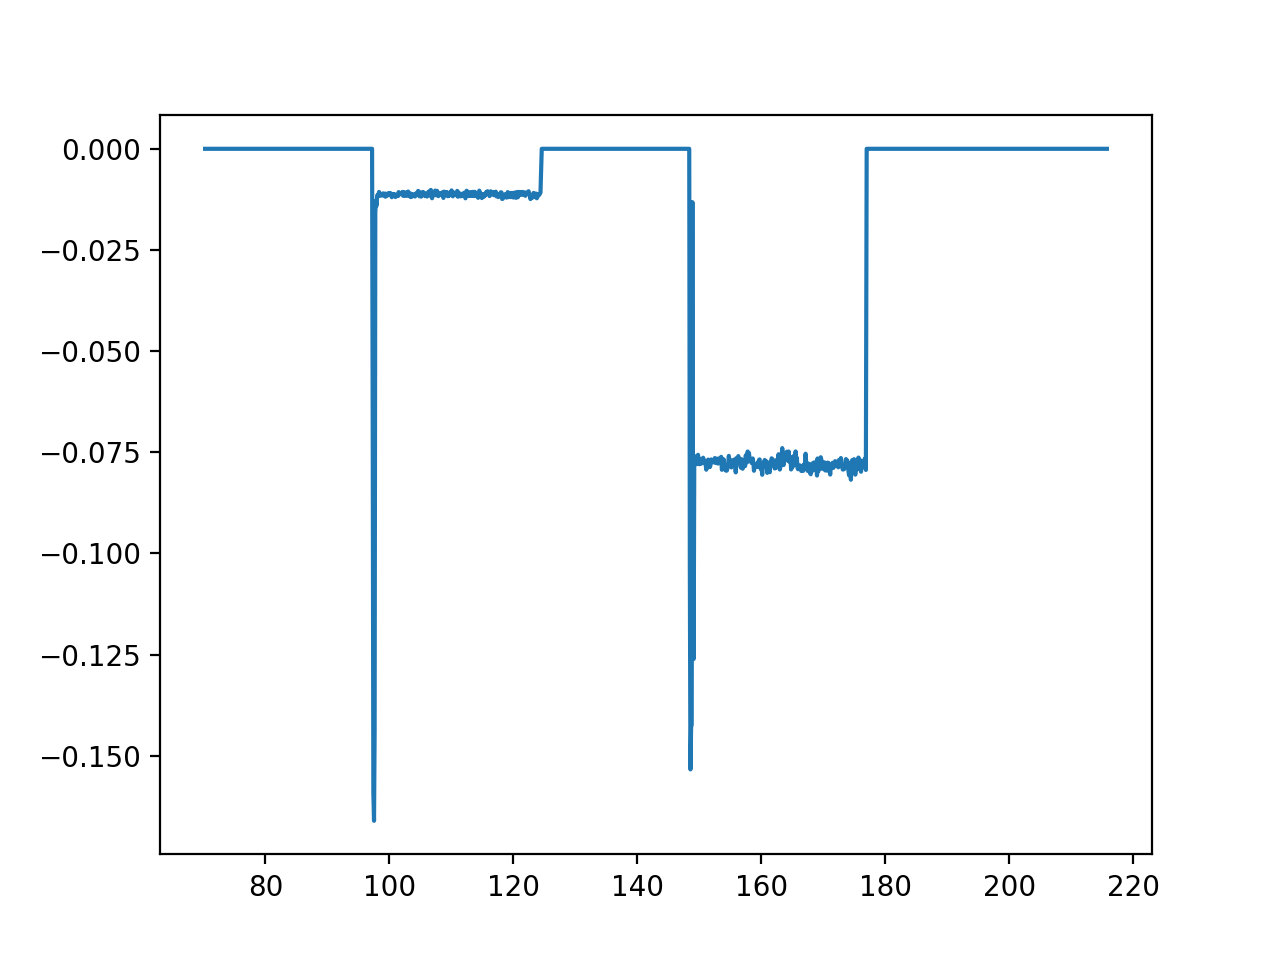

In [286]:
plt.figure()
plt.plot(battery.simt[:],-R0*battery.simi)

<IPython.core.display.Javascript object>


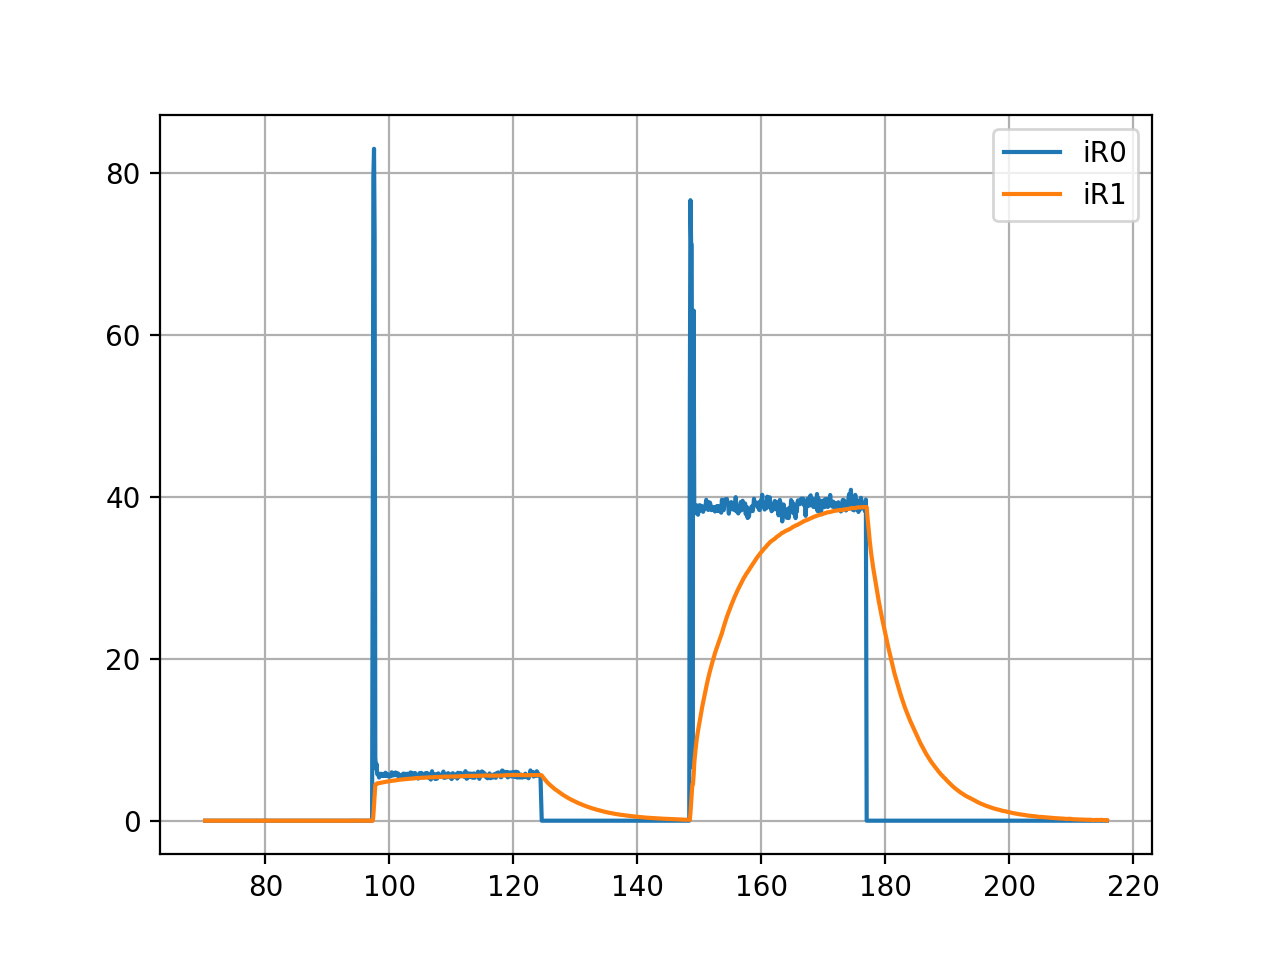

In [287]:
plt.figure()
plt.plot(battery.simt,battery.simi,label='iR0')
plt.plot(battery.simt[:n+1],xminus[1,:n+1],label='iR1')
plt.legend()
plt.grid()

# State of charge comparison

<IPython.core.display.Javascript object>


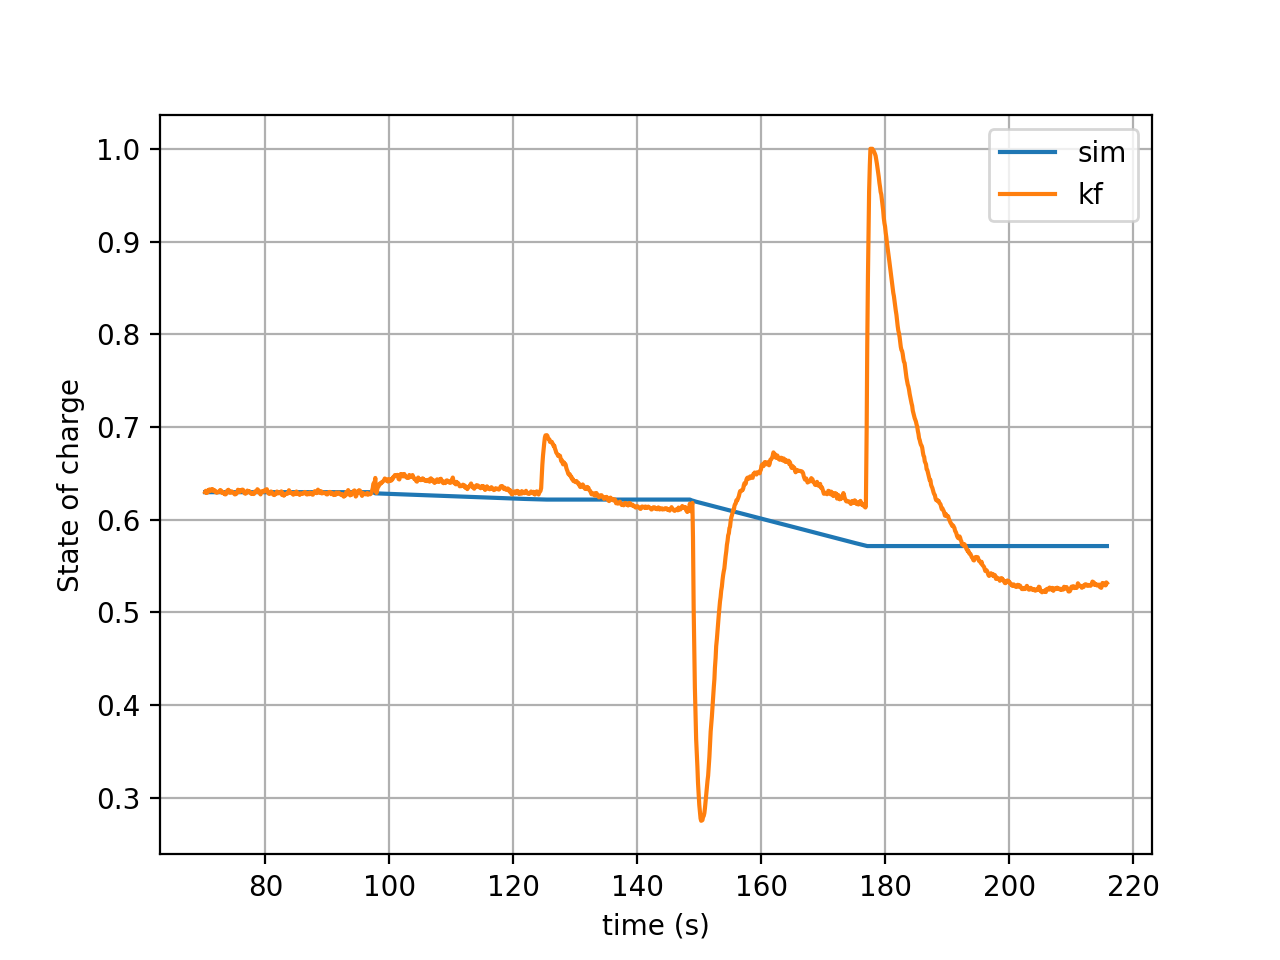

In [288]:
plt.figure()
plt.plot(battery.simt[:n+1],battery.simz[:n+1],label='sim')
plt.plot(battery.simt[:n+1],xplus[0,:],label='kf')
plt.xlabel('time (s)')
plt.ylabel('State of charge')
plt.legend()
plt.grid()
plt.show()

Real SOC is certainly more like the simulation one.

<IPython.core.display.Javascript object>


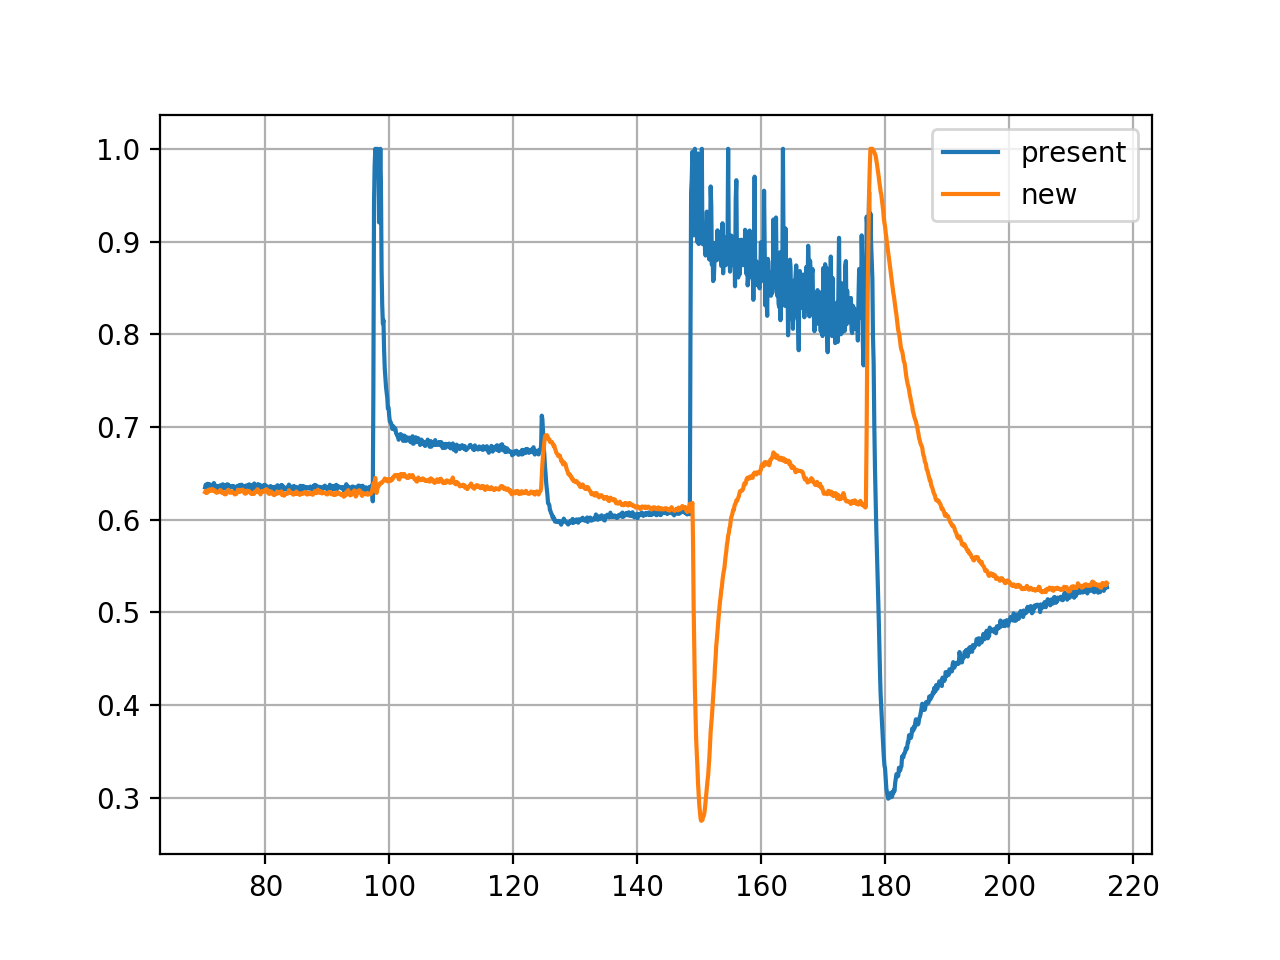

In [290]:
plt.figure()
plt.plot(time,SOC,label='present')
plt.plot(time[:n+1],xplus[0,:],label='new')
plt.legend()
plt.grid()